In [1]:
import yaml
import os
import numpy as np
import sys
import h5py
import matplotlib.pyplot as plt

### after you install bart 0.7.00 from https://mrirecon.github.io/bart/, import it as follows
sys.path.insert(0,'/cheng/bart-0.7.00/python/')
os.environ['TOOLBOX_PATH'] = "/cheng/bart-0.7.00/"
import bart

In [2]:
bart.bart

<function bart.bart(nargout, cmd, *args)>

In [10]:
## Saves sens maps as a single .h5 file per slice

with open('/cheng/metaMRI/metaMRI/data_dict/E11.1/P/knee_val_PD_Aera_15-19.yaml', 'r') as stream:
    filenames = yaml.safe_load(stream)

In [11]:
filenames

[{'filename': 'file1002241',
  'path': '/srv/knee/multicoil_train/file1002241.h5',
  'predefined_mask': None,
  'slice': 14},
 {'filename': 'file1002241',
  'path': '/srv/knee/multicoil_train/file1002241.h5',
  'predefined_mask': None,
  'slice': 15},
 {'filename': 'file1002241',
  'path': '/srv/knee/multicoil_train/file1002241.h5',
  'predefined_mask': None,
  'slice': 16},
 {'filename': 'file1002241',
  'path': '/srv/knee/multicoil_train/file1002241.h5',
  'predefined_mask': None,
  'slice': 17},
 {'filename': 'file1002241',
  'path': '/srv/knee/multicoil_train/file1002241.h5',
  'predefined_mask': None,
  'slice': 18},
 {'filename': 'file1000222',
  'path': '/srv/knee/multicoil_train/file1000222.h5',
  'predefined_mask': None,
  'slice': 14},
 {'filename': 'file1000222',
  'path': '/srv/knee/multicoil_train/file1000222.h5',
  'predefined_mask': None,
  'slice': 15},
 {'filename': 'file1000222',
  'path': '/srv/knee/multicoil_train/file1000222.h5',
  'predefined_mask': None,
  'slice

In [12]:
def apply_center_mask(kspace,center_fraction):
    num_cols = kspace.shape[-1]

    #center_fraction = 0.08
    acceleration = 4

    # create the mask
    num_low_freqs = int(round(num_cols * center_fraction))
    #print(num_low_freqs)
    num_high_freqs = round(num_cols / acceleration) - num_low_freqs
    pad = (num_cols - num_low_freqs + 1) // 2

    all_freqs_indices = np.arange(num_cols)
    all_high_freqs_indices = np.hstack((all_freqs_indices[: pad],all_freqs_indices[pad + num_low_freqs :]))

    chosen_high_freqs_indices = np.random.choice(all_high_freqs_indices, size=num_high_freqs, replace=False, p=None)

    mask = np.zeros(num_cols)
    
    mask[pad : pad + num_low_freqs] = 1.0
    #mask[chosen_high_freqs_indices] = 1.0
    #print(mask)
    
    mask_shape = [1 for _ in kspace.shape]
    mask_shape[-1] = num_cols
    mask = mask.reshape(*mask_shape)

    masked_kspace = kspace*mask + 0.0
    return masked_kspace, num_low_freqs

In [13]:
save_path = '/cheng/metaMRI/metaMRI/data_dict/E11.1/P/sensmap_val/'

counter = 0
for file in filenames:
    
    ## Load kspace
    with h5py.File(file["path"], "r") as hf:
        kspace_slice = hf["kspace"][file["slice"]]
    
    center_fraction = 0.08

    counter+=1
    print(counter)

    ## Apply mask only on the 0.08 center fraction
    masked_kspace, num_low_freqs = apply_center_mask(kspace_slice,center_fraction)

    ## Compute sens map
    sens_maps = bart.bart(1, f'ecalib -d0 -m1', np.array([np.moveaxis(masked_kspace,0,2)]))
    sens_maps = np.moveaxis(sens_maps[0],2,0)   

    ## Save sens map
    sensmap_fname = file["filename"] + '_smaps_slice' + str(file["slice"]) + '.h5'
    with h5py.File(save_path + sensmap_fname, "w") as hf:
        hf.create_dataset('sens_maps', data=sens_maps)  

1
Done.
2
Done.
3
Done.
4
Done.
5
Done.
6
Done.
7
Done.
8
Done.
9
Done.
10
Done.
11
Done.
12
Done.
13
Done.
14
Done.
15
Done.
16
Done.
17
Done.
18
Done.
19
Done.
20
Done.
21
Done.
22
Done.
23
Done.
24
Done.
25
Done.
26
Done.
27
Done.
28
Done.
29
Done.
30
Done.
31
Done.
32
Done.
33
Done.
34
Done.
35
Done.
36
Done.
37
Done.
38
Done.
39
Done.
40
Done.
41
Done.
42
Done.
43
Done.
44
Done.
45
Done.
46
Done.
47
Done.
48
Done.
49
Done.
50
Done.
51
Done.
52
Done.
53
Done.
54
Done.
55
Done.
56
Done.
57
Done.
58
Done.
59
Done.
60
Done.
61
Done.
62
Done.
63
Done.
64
Done.
65
Done.
66
Done.
67
Done.
68
Done.
69
Done.
70
Done.
71
Done.
72
Done.
73
Done.
74
Done.
75
Done.
76
Done.
77
Done.
78
Done.
79
Done.
80
Done.
81
Done.
82
Done.
83
Done.
84
Done.
85
Done.
86
Done.
87
Done.
88
Done.
89
Done.
90
Done.
91
Done.
92
Done.
93
Done.
94
Done.
95
Done.
96
Done.
97
Done.
98
Done.
99
Done.
100
Done.
101
Done.
102
Done.
103
Done.
104
Done.
105
Done.
106
Done.
107
Done.
108
Done.
109
Done.
110
Done.
111
Done

In [7]:
print(sens_maps.shape)

(15, 640, 372)


(-0.5, 371.5, 639.5, -0.5)

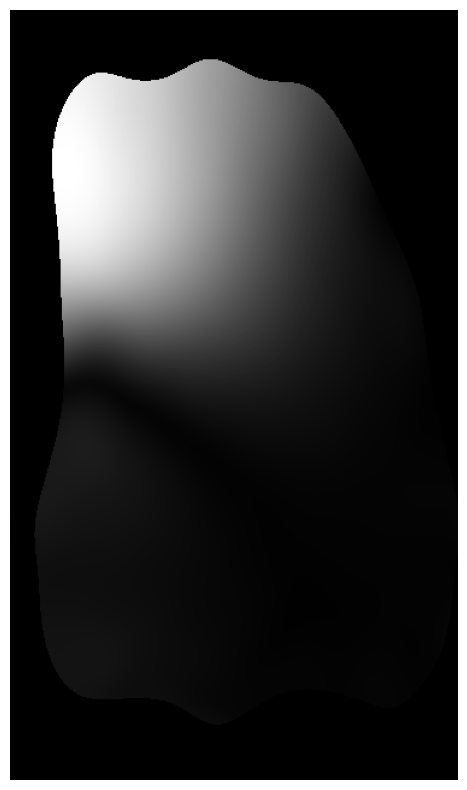

In [14]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.imshow(np.abs(sens_maps[0]),'gray')
ax.axis('off')